In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jute-pest/Jute_Pest_Dataset/val/Mealybug/Mealy-Bug_247_png.rf.80a231d0c5dc022eb6db1d0c44f14982.jpg
/kaggle/input/jute-pest/Jute_Pest_Dataset/val/Mealybug/Mealy-Bug_244_png.rf.7fa17fdd558d7d53bfcd039c354b5cd3.jpg
/kaggle/input/jute-pest/Jute_Pest_Dataset/val/Mealybug/Mealy-Bug_318_png.rf.5f599054897a844872de2abd2817b498.jpg
/kaggle/input/jute-pest/Jute_Pest_Dataset/val/Mealybug/Mealy-Bug_320_png.rf.881446b481b41f61f82d0aeb60af53e9.jpg
/kaggle/input/jute-pest/Jute_Pest_Dataset/val/Mealybug/Mealy-Bug_323_png.rf.539d1cea73d4f26734c0ddcfa47561b2.jpg
/kaggle/input/jute-pest/Jute_Pest_Dataset/val/Mealybug/Mealy-Bug_249_png.rf.012f72288d5be0ce92a40127b5b7096e.jpg
/kaggle/input/jute-pest/Jute_Pest_Dataset/val/Mealybug/Mealy-Bug_333_png.rf.9f1e1ce7b6a86bb495a83c1bf7d43466.jpg
/kaggle/input/jute-pest/Jute_Pest_Dataset/val/Mealybug/HGIC_IndoorPlants_Mealybugs_5573436_1600.jpg
/kaggle/input/jute-pest/Jute_Pest_Dataset/val/Mealybug/Citrus-mealybug-3-1.jpg
/kaggle/input/jute-pest/Jute_P

In [2]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset


In [3]:
# Load the pretrained ResNet model
model = models.resnet50(pretrained=True)

# Modify the final layer to match the number of classes in your dataset
num_classes = 17  # Change this to match your dataset's number of classes
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Send the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 174MB/s] 


In [4]:
device

device(type='cuda')

In [5]:
from torchvision.datasets import ImageFolder

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load your dataset
train_dataset = ImageFolder(root='/kaggle/input/jute-pest/Jute_Pest_Dataset/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = ImageFolder(root='/kaggle/input/jute-pest/Jute_Pest_Dataset/test', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [7]:
train_count = len(train_dataset)

In [9]:
from tqdm import tqdm

# Training loop
epochs = 20

# Initialize lists to store values
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    model.train()
    train_loss = 0.0
    total = 0
    correct = 0

    # Training with a progress bar
    train_progress = tqdm(train_loader, desc="Training", leave=False)
    for images, labels in train_progress:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate predictions and update accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update loss
        train_loss += loss.item()
        train_progress.set_postfix(loss=loss.item())
        

    train_losses.append(train_loss/len(train_loader))
    train_accuracies.append(100 * correct / total)
    print(f"Training Loss: {train_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    val_progress = tqdm(val_loader, desc="Validation", leave=False)
    with torch.no_grad():
        for images, labels in val_progress:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            # Calculate predictions and update accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_progress.set_postfix(loss=loss.item())
            
            
    test_accuracies.append(100 * correct / total)
    test_losses.append(val_loss/len(val_loader))
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")


Epoch 1/20


Training Loss: 0.2726, Accuracy: 93.67%


Validation Loss: 0.0701, Accuracy: 98.15%
Epoch 2/20


Training Loss: 0.0596, Accuracy: 98.42%


Validation Loss: 0.0853, Accuracy: 97.36%
Epoch 3/20


Training Loss: 0.0524, Accuracy: 98.65%


Validation Loss: 0.0872, Accuracy: 97.10%
Epoch 4/20


Training Loss: 0.0461, Accuracy: 98.77%


Validation Loss: 0.1505, Accuracy: 95.78%
Epoch 5/20


Training Loss: 0.0376, Accuracy: 98.84%


Validation Loss: 0.0842, Accuracy: 97.36%
Epoch 6/20


Training Loss: 0.0259, Accuracy: 99.35%


Validation Loss: 0.0834, Accuracy: 97.89%
Epoch 7/20


Training Loss: 0.0202, Accuracy: 99.52%


Validation Loss: 0.0874, Accuracy: 98.42%
Epoch 8/20


Training Loss: 0.0401, Accuracy: 98.87%


Validation Loss: 0.0924, Accuracy: 96.31%
Epoch 9/20


Training Loss: 0.0240, Accuracy: 99.36%


Validation Loss: 0.0816, Accuracy: 97.36%
Epoch 10/20


Training Loss: 0.0160, Accuracy: 99.57%


Validation Loss: 0.0782, Accuracy: 97.63%
Epoch 11/20


Training Loss: 0.0241, Accuracy: 99.44%


Validation Loss: 0.0989, Accuracy: 97.10%
Epoch 12/20


Training Loss: 0.0176, Accuracy: 99.61%


Validation Loss: 0.0331, Accuracy: 98.94%
Epoch 13/20


Training Loss: 0.0075, Accuracy: 99.86%


Validation Loss: 0.0511, Accuracy: 98.42%
Epoch 14/20


Training Loss: 0.0056, Accuracy: 99.88%


Validation Loss: 0.0798, Accuracy: 98.15%
Epoch 15/20


Training Loss: 0.0820, Accuracy: 97.77%


Validation Loss: 0.1238, Accuracy: 97.36%
Epoch 16/20


Training Loss: 0.0280, Accuracy: 99.15%


Validation Loss: 0.0958, Accuracy: 97.63%
Epoch 17/20


Training Loss: 0.0103, Accuracy: 99.78%


Validation Loss: 0.0747, Accuracy: 98.94%
Epoch 18/20


Training Loss: 0.0111, Accuracy: 99.74%


Validation Loss: 0.0665, Accuracy: 98.15%
Epoch 19/20


Training Loss: 0.0114, Accuracy: 99.66%


Validation Loss: 0.1074, Accuracy: 97.63%
Epoch 20/20


Training Loss: 0.0140, Accuracy: 99.61%


Validation Loss: 0.1221, Accuracy: 96.31%


In [10]:
train_losses

[0.27256475175998296,
 0.05960349409177088,
 0.052351341613955646,
 0.04607370088803628,
 0.03764886197364327,
 0.025918888783953754,
 0.020236884740424472,
 0.040110011804632216,
 0.024033821386165253,
 0.01598394279916296,
 0.02408061861112428,
 0.01758823642221344,
 0.007504768924191732,
 0.005592327823107175,
 0.0819772514808545,
 0.02799222791336343,
 0.010270446097541089,
 0.011118752860921172,
 0.01142390282671336,
 0.013961163682414745]

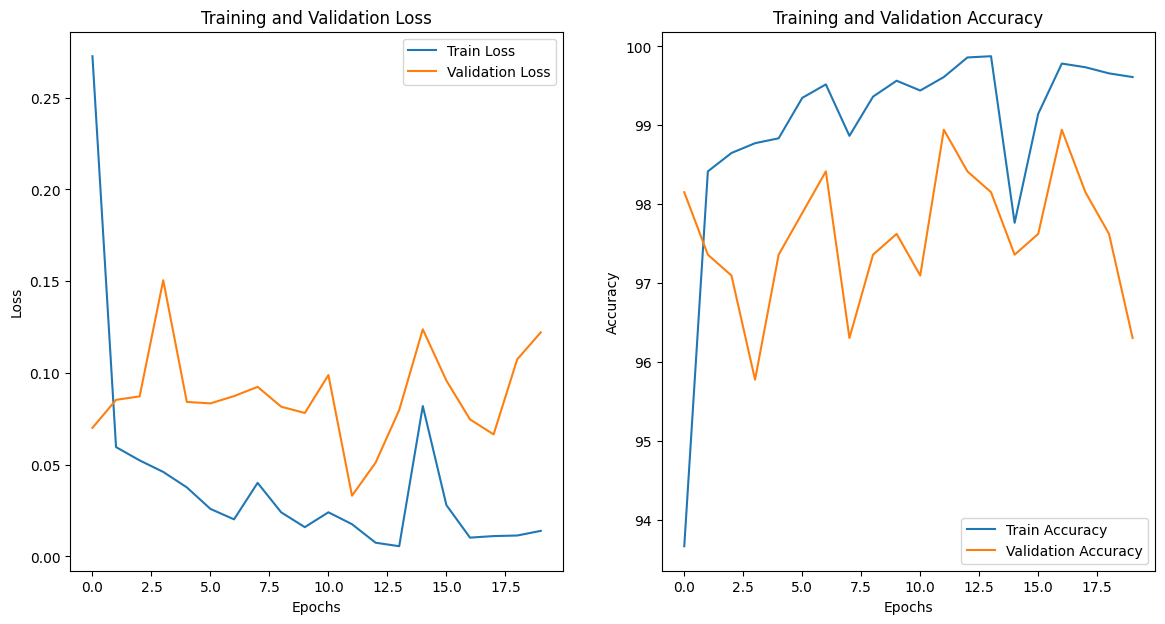

In [11]:
import matplotlib.pyplot as plt
epochs_range = range(epochs)

plt.figure(figsize=(14, 7))

# Plot Train and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, test_losses, label
         ='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Train and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, test_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Accuracy: 88.38%


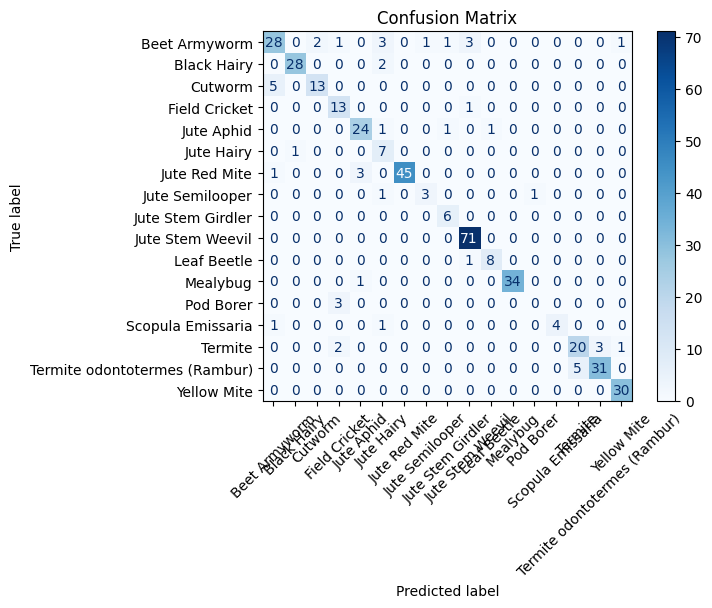

In [12]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Assuming the model, criterion, and device are already defined
# model = ...
# criterion = ...
# device = ...

# Transform to apply to validation images (example)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation loop
model.eval()  # Set the model to evaluation mode
val_loss = 0.0
correct = 0
total = 0

all_labels = []  # To store all true labels
all_predictions = []  # To store all predicted labels

# Load the validation dataset and create the DataLoader
val_dataset = ImageFolder(root='/kaggle/input/jute-pest/Jute_Pest_Dataset/val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize a progress bar
val_progress = tqdm(val_loader, desc="Validation", leave=False)

# No gradients are needed for validation, so use torch.no_grad()
with torch.no_grad():
    for images, labels in val_progress:
        images, labels = images.to(device), labels.to(device)  # Move data to device (GPU/CPU)
        
        # Forward pass through the model
        outputs = model(images)
        
        # Get predicted labels
        _, predicted = torch.max(outputs, 1)
        
        # Append true and predicted labels for confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        
        # Update total and correct counts for accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy: {accuracy:.2f}%")

# Confusion matrix
class_names = val_dataset.classes  # Retrieve class names from the dataset
cm = confusion_matrix(all_labels, all_predictions, labels=np.arange(len(class_names)))

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()
